In [1]:
import numpy as np
import torch
import sklearn

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

In [3]:
y = mnist.target
x = mnist.data
print(type(y))
print(x.shape)

<class 'numpy.ndarray'>
(70000, 784)


In [4]:
x = x.reshape((70000, 28, 28))

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 17)
x_train, x_val, y_train, y_val =  train_test_split(x_train, y_train, test_size=0.2, random_state=40)
print('%d train, %d validation, %d test data' % (len(x_train), len(x_val), len(x_test)))

39200 train, 9800 validation, 21000 test data


In [7]:
class MyModel(torch.nn.Module):
  def __init__(self):

    super(MyModel, self).__init__()

    self.features = torch.nn.Sequential( # Inp: B 1 28 28
        torch.nn.Conv2d(1, 32, 3, stride=1, padding=0), # B 32 26 26
        torch.nn.ReLU(),
        torch.nn.Conv2d(32, 32, 3, stride=1, padding=0), # B 32 24 24
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2, stride=2, padding=0), # B 32 12 12

        torch.nn.Conv2d(32, 64, 3, stride=1, padding=0), # B 64 10 10
        torch.nn.ReLU(),
        torch.nn.Conv2d(64, 64, 3, stride=1, padding=0), # B  64 8 8
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2, stride=2, padding=0), # B 64 4 4
        
        torch.nn.Conv2d(64, 128, 3, stride=1, padding=0), # B 128 2 2
        torch.nn.ReLU()

    )

    self.decider = torch.nn.Sequential(
        torch.nn.Dropout(0.5),
        torch.nn.Linear(4 * 128, 128), # B 128
        torch.nn.ReLU(),
        torch.nn.Linear(128, 10) # B 10
    )

    self.log_prob_cal = torch.nn.LogSoftmax(dim = 1) # B 10


  def forward(self, b_x, b_y = None):
      conv_features = self.features(b_x)
      class_scores = self.decider(conv_features.flatten(1))
      log_probs = self.log_prob_cal(class_scores)
      loss = -1 * torch.mean(log_probs[torch.arange(b_x.shape[0]), b_y])
      decision = torch.argmax(log_probs, dim = -1)
      return decision, loss

In [8]:
model = MyModel()
model = model.cuda()

In [9]:
for n, v in model.named_parameters():
  print(n)

features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
decider.1.weight
decider.1.bias
decider.3.weight
decider.3.bias


In [10]:
batch_size = 64
batch_x_placeholder = torch.zeros(size= [batch_size, 1, 28, 28], dtype = torch.float32, device =torch.device('cuda:0'))
batch_y_placeholder = torch.zeros(size= [batch_size], dtype = torch.long, device = torch.device('cuda:0'))
epochs = 10
train_loss = np.zeros((epochs,))
val_loss = np.zeros((epochs,))
train_acc = np.zeros((epochs,))
val_acc = np.zeros((epochs,))


In [11]:
optimizer = torch.optim.Adam(filter(
    lambda p : p.requires_grad, model.parameters()),
    lr = 0.001
)

In [12]:
from time import time

In [13]:
iters_per_epoch = int(np.ceil(1.0 * len(x_train) / batch_size))

for e in range(epochs):
    t_start = time()

    model.train() # training phase

    # shuffling
    inds = np.arange(len(x_train))
    np.random.shuffle(inds)

    epoch_loss = 0
    true_positive = 0


    # iterating over the whole training set
    for iter in range(iters_per_epoch):

        batch_inds = inds[iter * batch_size: min(len(inds), (iter + 1) * batch_size)]

        # reshaping placeholders
        if len(batch_inds) != len(batch_x_placeholder):
            batch_x_placeholder.resize_([len(batch_inds), 1, 28, 28])
            batch_y_placeholder.resize_([len(batch_inds)])

        batch_x_placeholder.copy_(torch.Tensor(x_train[batch_inds, np.newaxis, :, :]))
        batch_y_placeholder.copy_(torch.Tensor(y_train[batch_inds].astype(int)))

        b_decision, b_loss = model(batch_x_placeholder, batch_y_placeholder)
        b_decision = b_decision.cpu().numpy()
      
        epoch_loss += float(b_loss) / iters_per_epoch  # CARE: WE SHOULD USE FLOAT OVER LOSS
        true_positive += np.sum(y_train[batch_inds].astype(int) == b_decision)

        b_loss.backward() # calculates derivations

        optimizer.step()
        optimizer.zero_grad() # CARE: MUST DO

    epoch_train_accuracy = true_positive * 100.0 / len(x_train)
    train_loss[e] = epoch_loss
    train_acc[e] = epoch_train_accuracy
    
 # Validating over validation data
    with torch.no_grad():
        model.eval()  # validation phase

        val_inds = np.arange(len(x_val))

        val_iters_per_epoch = int(np.ceil(1.0 * len(x_val) / batch_size))

        epoch_validation_loss = 0
        val_true_positive = 0


        # iterating over the whole training set
        for iter in range(val_iters_per_epoch):

            val_batch_inds = val_inds[iter * batch_size: min(len(val_inds), (iter + 1) * batch_size)]

            # reshaping placeholders
            if len(val_batch_inds) != len(batch_x_placeholder):
                batch_x_placeholder.resize_([len(val_batch_inds), 1, 28, 28])
                batch_y_placeholder.resize_([len(val_batch_inds)])

            batch_x_placeholder.copy_(torch.Tensor(x_val[val_batch_inds, np.newaxis, :, :]))
            batch_y_placeholder.copy_(torch.Tensor(y_val[val_batch_inds].astype(int)))

            b_decision, b_loss = model(batch_x_placeholder, batch_y_placeholder)
            b_decision = b_decision.cpu().numpy()
        
            epoch_validation_loss += float(b_loss) / val_iters_per_epoch  # CARE: WE SHOULD USE FLOAT OVER LOSS
            val_true_positive += np.sum(y_val[val_batch_inds].astype(int) == b_decision)
                
        epoch_validation_accuracy = val_true_positive * 100.0 / len(x_val)
        val_loss[e] = epoch_validation_loss
        val_acc[e] = epoch_validation_accuracy
        # TO Complete
    
    print(f'Train epoch Loss: {epoch_loss:.4f}, train accuracy: {epoch_train_accuracy:.2f}, Validation Loss: {epoch_validation_loss:.4f}, validation accuracy: {epoch_validation_accuracy:.2f}')

    # Saving the model and optimizer state
    torch.save({
            'epoch': e,
            'optimizer_state_dict': optimizer.state_dict(),
            'model_state_dict': model.state_dict(),
            'train_loss': epoch_loss,
            'train_accuracy': epoch_train_accuracy,
            'validation_loss': epoch_validation_loss,
            'validation_accuracy': epoch_validation_accuracy
        }, 'epoch_%d_state.pt' % e)

    print('Epoch %d ended in %.2f secs.' % (e, time() - t_start,))



Train epoch Loss: 0.2018, train accuracy: 93.61, Validation Loss: 0.0742, validation accuracy: 97.73
Epoch 0 ended in 2.94 secs.
Train epoch Loss: 0.0706, train accuracy: 97.93, Validation Loss: 0.0533, validation accuracy: 98.45
Epoch 1 ended in 3.03 secs.
Train epoch Loss: 0.0506, train accuracy: 98.53, Validation Loss: 0.0462, validation accuracy: 98.68
Epoch 2 ended in 2.90 secs.
Train epoch Loss: 0.0457, train accuracy: 98.57, Validation Loss: 0.0422, validation accuracy: 98.85
Epoch 3 ended in 2.92 secs.
Train epoch Loss: 0.0367, train accuracy: 98.89, Validation Loss: 0.0539, validation accuracy: 98.44
Epoch 4 ended in 3.02 secs.
Train epoch Loss: 0.0377, train accuracy: 98.84, Validation Loss: 0.0443, validation accuracy: 98.83
Epoch 5 ended in 3.03 secs.
Train epoch Loss: 0.0311, train accuracy: 99.07, Validation Loss: 0.0563, validation accuracy: 98.57
Epoch 6 ended in 3.02 secs.
Train epoch Loss: 0.0318, train accuracy: 99.06, Validation Loss: 0.0390, validation accuracy: 99

In [14]:
import matplotlib.pyplot as plt

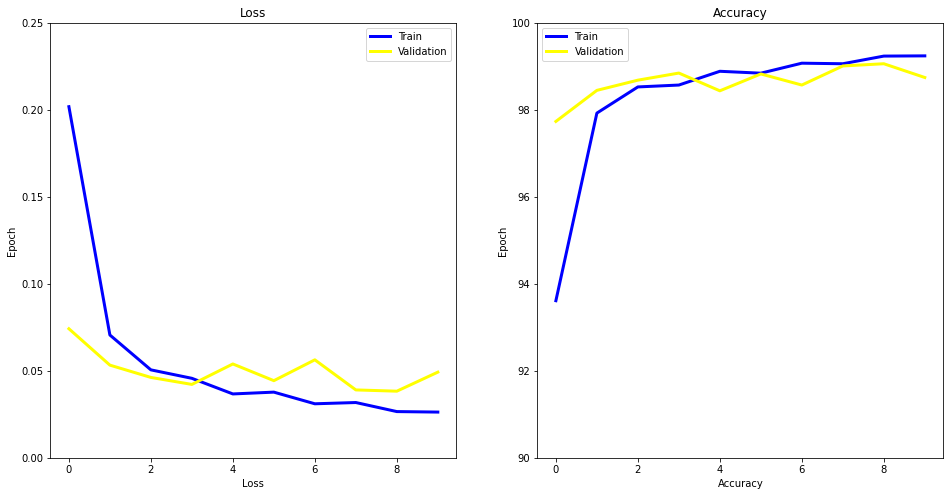

In [15]:
fig = plt.figure(figsize=(16, 8))


# loss
ax = fig.add_subplot(121)
ax.set_title('Loss')
ax.set_xlabel('Loss')
ax.set_ylabel('Epoch')
ax.set_aspect('auto')

plt.plot(train_loss, label='Train', color='blue', linewidth=3)
plt.plot(val_loss, label='Validation', color='yellow', linewidth=3)
plt.ylim(0, 0.250)

plt.legend()

# acc
ax = fig.add_subplot(122)
ax.set_title('Accuracy')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Epoch')
ax.set_aspect('auto')
plt.ylim((90, 100))

plt.plot(train_acc, label='Train', color='blue', linewidth=3)
plt.plot(val_acc, label='Validation', color='yellow', linewidth=3)


plt.legend()

In [16]:


with torch.no_grad():
        model.eval()  # validation phase

        val_inds = np.arange(len(x_test))

        val_iters_per_epoch = int(np.ceil(1.0 * len(x_test) / batch_size))

        epoch_validation_loss = 0
        val_true_positive = 0
        predictions = []

        # iterating over the whole training set
        for iter in range(val_iters_per_epoch):

            val_batch_inds = val_inds[iter * batch_size: min(len(val_inds), (iter + 1) * batch_size)]

            # reshaping placeholders
            if len(val_batch_inds) != len(batch_x_placeholder):
                batch_x_placeholder.resize_([len(val_batch_inds), 1, 28, 28])
                batch_y_placeholder.resize_([len(val_batch_inds)])

            batch_x_placeholder.copy_(torch.Tensor(x_test[val_batch_inds, np.newaxis, :, :]))
            batch_y_placeholder.copy_(torch.Tensor(y_test[val_batch_inds].astype(int)))

            b_decision, b_loss = model(batch_x_placeholder, batch_y_placeholder)
            b_decision = b_decision.cpu().numpy()

            predictions.append(b_decision)
        
            epoch_validation_loss += float(b_loss) / val_iters_per_epoch  # CARE: WE SHOULD USE FLOAT OVER LOSS
            val_true_positive += np.sum(y_test[val_batch_inds].astype(int) == b_decision)
                
        epoch_validation_accuracy = val_true_positive * 100.0 / len(x_test)
        val_loss = epoch_validation_loss
        val_acc = epoch_validation_accuracy


print('Test Loss %.4f , Accuracy: %.2f' % (val_loss, val_acc))

Test Loss 0.0462 , Accuracy: 98.81


In [18]:
y_test = y_test.astype(int)
predictions = np.concatenate(predictions)

there are 20751 correct predictions. We have chosen a few of them randomly.


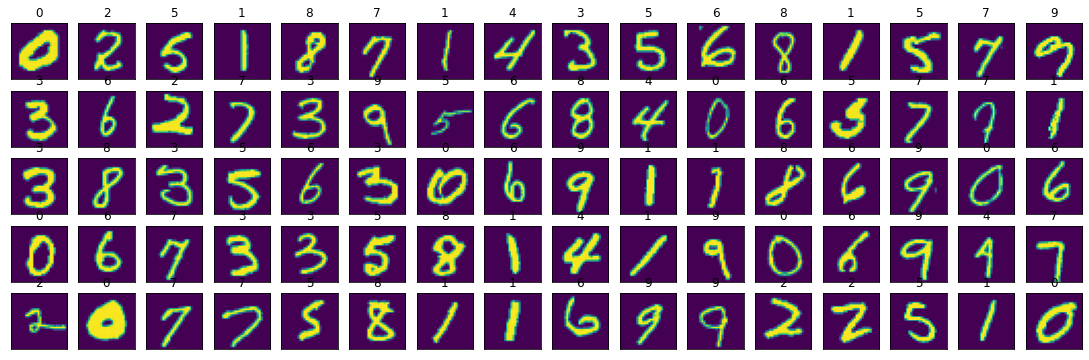

In [19]:
right_images = x_test[predictions == y_test]
print('there are %d correct predictions. We have chosen a few of them randomly.' % len(right_images))
right_labels = predictions[predictions == y_test]
right_indices = np.random.choice(np.arange(len(right_images)), size=80)

images = right_images[right_indices]
label_predictions = right_labels[right_indices]
texts = [f'{label_predictions[i]}' for i in range(len(right_indices))]
columns = 16
rows = 5

fig = plt.figure(figsize=(1.2 * columns, 1.2 * rows))

for i in range(columns * rows):
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.set_title(texts[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(images[i].reshape((28, 28)))